In [204]:
import seaborn as sns
import seaborn.objects as so
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import fastf1 as ff1
import fastf1.plotting

from sklearn.cluster import KMeans, DBSCAN

# use a default session to set color maps etc
year = 2024
circuit = 'Japan'
session = 'Q'
race = ff1.get_session(year, circuit, session)

In [217]:
# summarise driver performance
dp = pd.read_pickle('data/driver_performance.pkl')[['event', 'driver', 'team', 'best_quali_lap_time', 'total_brake_time_quali', 'avg_race_pace', 'lap_time_consistency','corner_avg']]
drivers_to_exclude = ['DOO','BEA','LAW','COL','SAR','RIC'] #limit to drivers with close to a full season of information
dp = dp[~dp['driver'].isin(drivers_to_exclude)]
print('Drivers of Interest = ', dp['driver'].unique())
driver_data = dp.groupby('driver')[['total_brake_time_quali', 'corner_avg', 'avg_race_pace', 'lap_time_consistency']].mean().reset_index()
driver_data

Drivers of Interest =  ['ALB' 'ALO' 'BOT' 'GAS' 'HAM' 'HUL' 'LEC' 'MAG' 'NOR' 'PER' 'PIA' 'RUS'
 'SAI' 'STR' 'TSU' 'VER' 'ZHO' 'OCO']


,driver,total_brake_time_quali,corner_avg,avg_race_pace,lap_time_consistency
0,ALB,0.503895,-0.413109,0.627448,0.139198
1,ALO,-0.385521,0.088192,0.122474,0.195327
2,BOT,0.637762,-0.613069,0.932423,0.420220
3,GAS,-0.647785,-0.209771,0.497003,0.473367
4,HAM,0.013060,0.360576,-0.714008,-0.272423
5,HUL,0.154504,-0.210369,0.250393,-0.094911
6,LEC,-0.132599,0.678519,-0.882938,-0.358297
7,MAG,0.617763,-0.316889,0.517667,0.283595
8,NOR,-1.026202,0.775301,-1.275287,-0.271577
9,OCO,1.738156,-0.421355,0.697670,0.322129


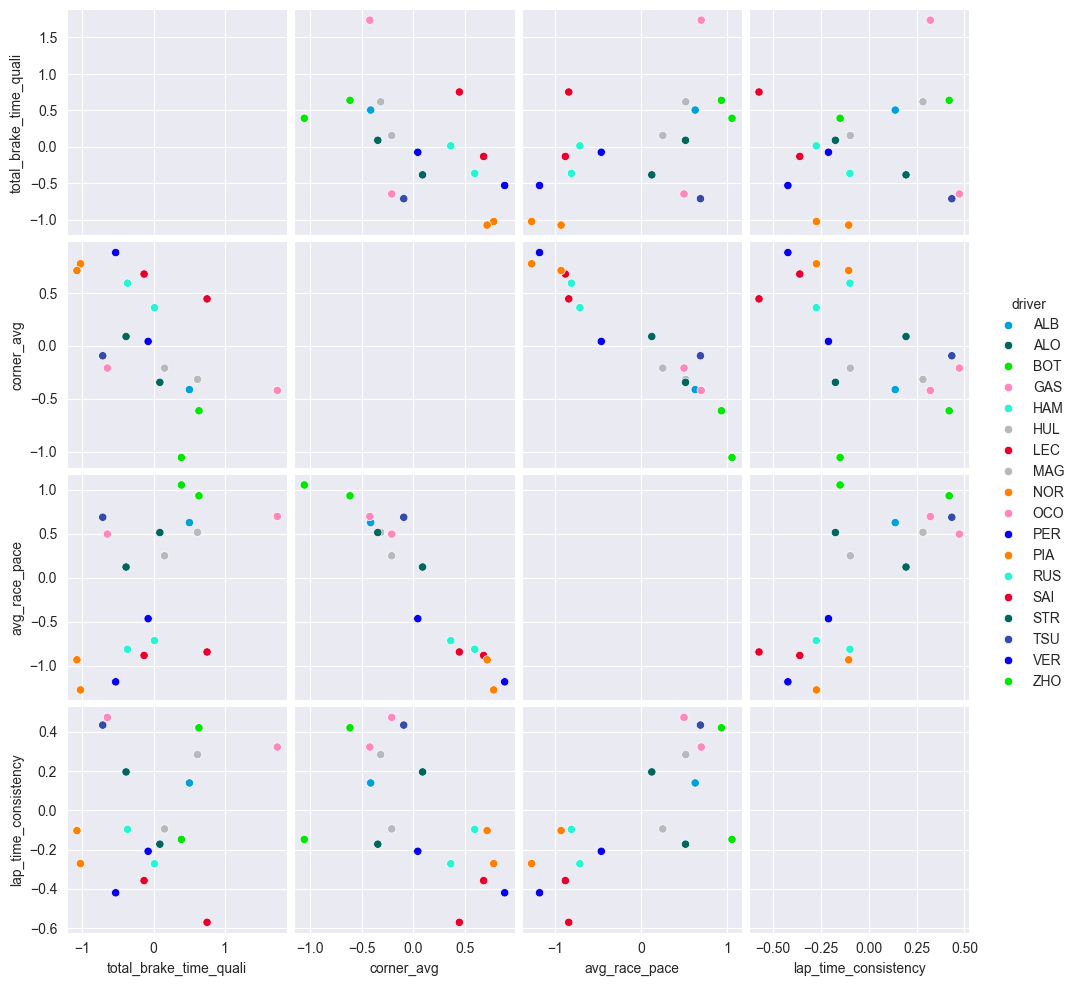

In [218]:
# Display basic information about the dataset
def f1_pairplot(pair_data):
    sns.pairplot(data = pair_data,
                 hue = 'driver',
                 palette=fastf1.plotting.get_driver_color_mapping(session=race)
                 )

f1_pairplot(driver_data)

In [219]:
# Clustering
model_data = driver_data.iloc[:,1:]    # remove non float data
print(model_data.info())
# Handle missing data - if any
print(driver_data.loc[driver_data.isnull().any(axis=1)])
model_data.fillna(model_data.mean(), inplace=True)  # Simple mean imputation

# K-means clustering
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(model_data)

driver_data['kmeans'] = kmeans_labels


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   total_brake_time_quali  18 non-null     float64
 1   corner_avg              18 non-null     float64
 2   avg_race_pace           18 non-null     float64
 3   lap_time_consistency    18 non-null     float64
dtypes: float64(4)
memory usage: 708.0 bytes
None
Empty DataFrame
Columns: [driver, total_brake_time_quali, corner_avg, avg_race_pace, lap_time_consistency]
Index: []


In [220]:
driver_data.groupby('kmeans')['driver'].apply(list)

kmeans
0                   [ALB, BOT, MAG, OCO, ZHO]
1    [HAM, LEC, NOR, PER, PIA, RUS, SAI, VER]
2                   [ALO, GAS, HUL, STR, TSU]
Name: driver, dtype: object

In [221]:
driver_data['kmeans'] = driver_data['kmeans'].astype('category').cat.rename_categories({0:"Laggards",1:"Front Runners",2:"Midfield"})

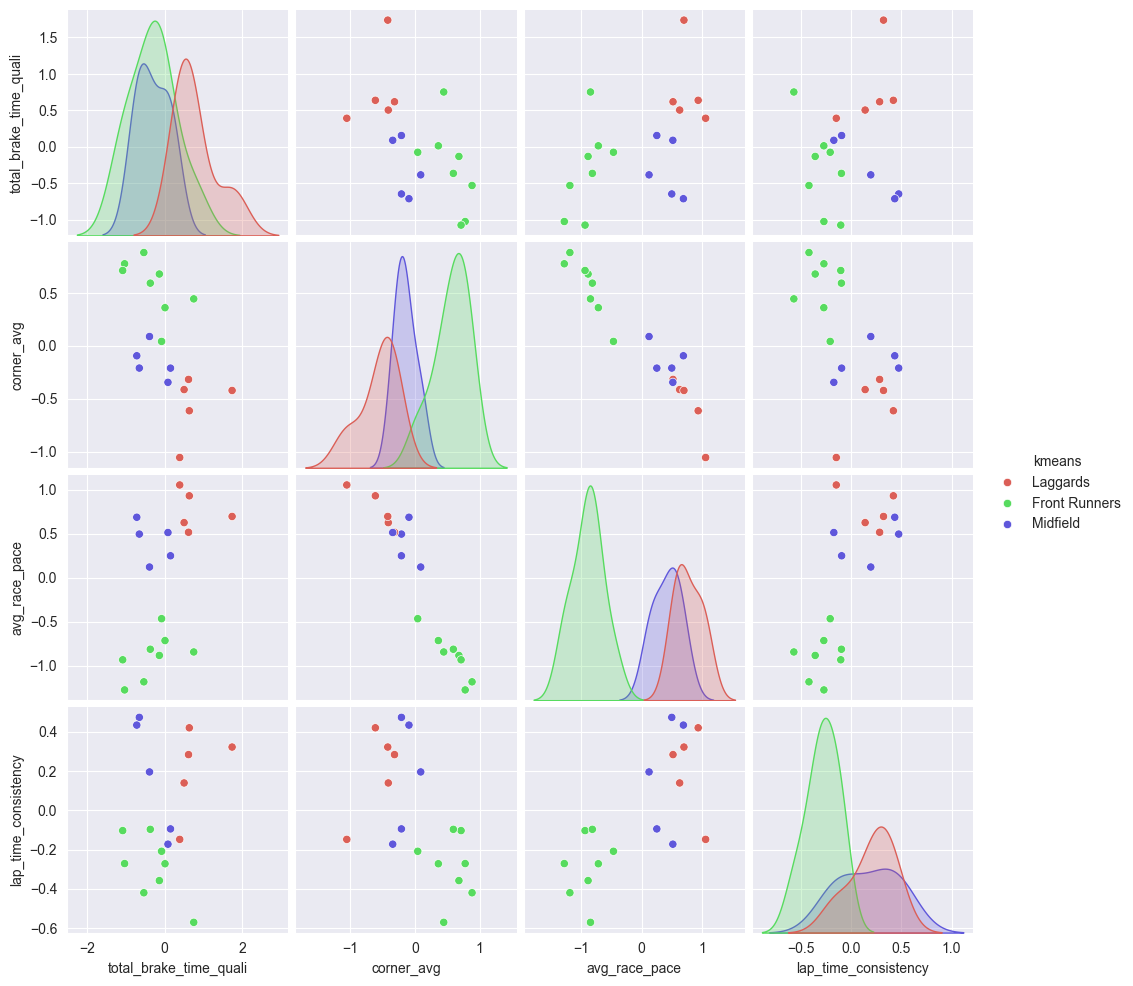

In [222]:
sns.pairplot(data = driver_data,
            hue = 'kmeans',
            palette = 'hls'
                 )

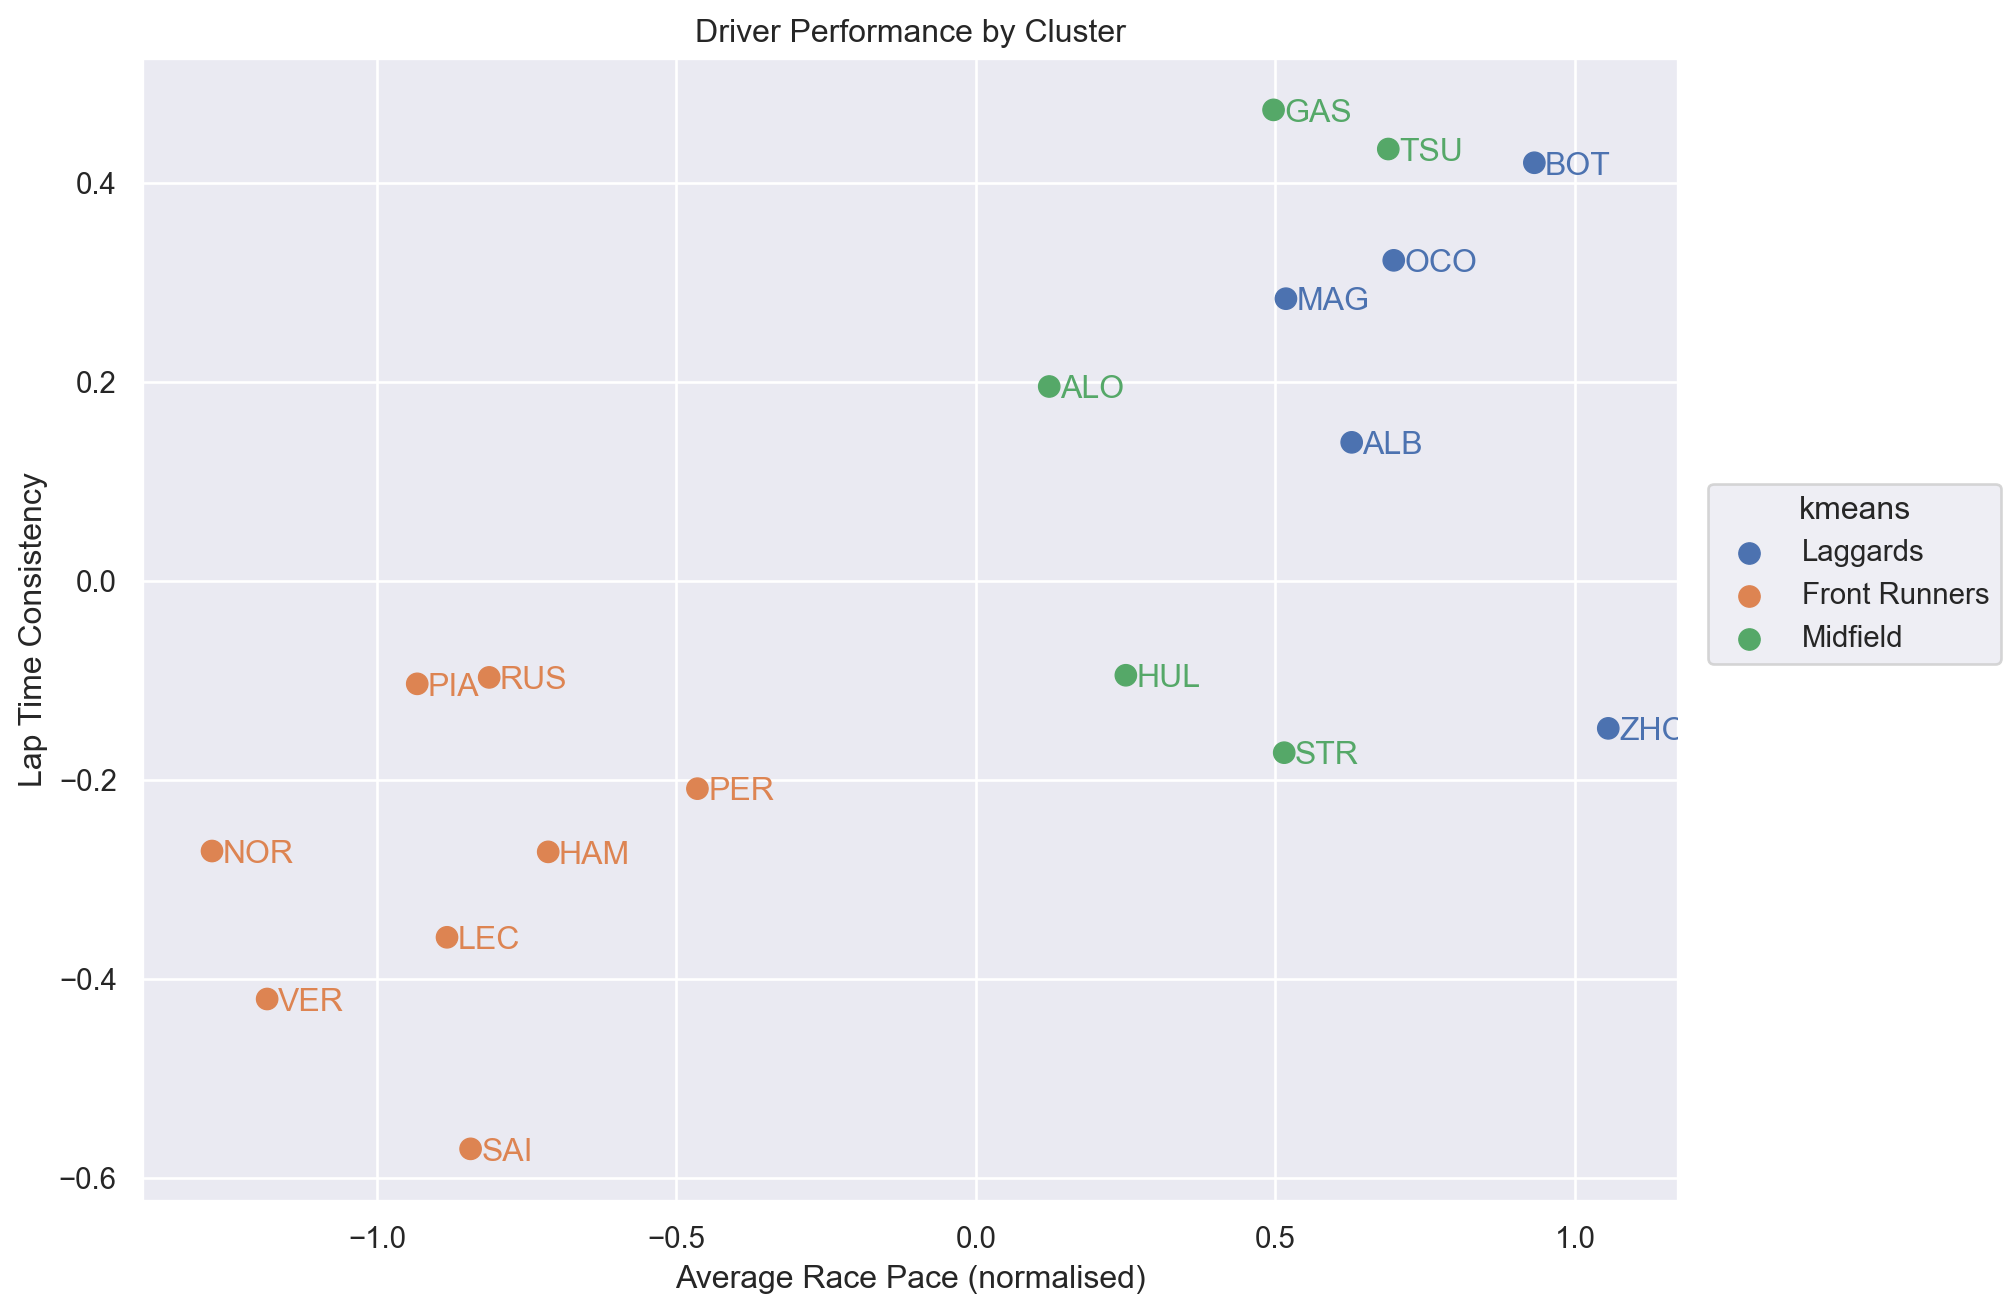

In [223]:
(
    so.Plot(driver_data, x="avg_race_pace", y="lap_time_consistency", color='kmeans', text="driver")
    .add(so.Dot(pointsize=8))
    .add(so.Text(halign="left"))
    .label(title='Driver Performance by Cluster', x='Average Race Pace (normalised)', y='Lap Time Consistency')
    .layout(size=(9, 7))
)